In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import random

In [2]:
golden_run_path = "cg_simulation/golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
golden_run_value = np.array(golden_run.value, dtype='float')
cg_fault_injection = pd.read_csv('cg_complete.csv')
SIZE = len(cg_fault_injection)

# Experiment 1
Take all the fault injections in the inital condition. Find all the fault injection cases that result into masked. For each masked case, compare error run with the golden run to get a error run curve. Combine all the error run curve to construct a error boundary for masked and SDC.

### SDC Ratio over entire program

In [8]:
iters = list(cg_fault_injection.iter)
iters.reverse()
count  = 0
last_zero_iteration_index = SIZE - iters.index(0)
dynamic_step_to_record_computation_result = int(last_zero_iteration_index/64)

for i in range(last_zero_iteration_index, len(iters)):
    if cg_fault_injection.outcome[i] == "SDC":
        count += 1

print("SDC ratio over entire program: ", count/len(iters))

SDC ratio over entire program:  0.07232583230579531


In [14]:
#only tracking the maximum value of the masked run after this time step.
tracking_length = len(golden_run_value)

def construct_boundary(number_of_dynamic_instruction):
    boundary = []
    ground_truth = {"Masked": 0, "SDC":0, "DUE":0}

    for i in range(tracking_length):
        boundary.append({'max':0, 'min':0})

    for i in range(number_of_dynamic_instruction):
        index = int(random.random() * SIZE)
        
        ground_truth[cg_fault_injection.outcome[index]] += 1
        
        if cg_fault_injection.outcome[index] == "Masked":
            masked_run_path = "cg_simulation/appstate_"+ str(index)+".log" 

            #Check whether the tracking file is on the path
            #TODO: check whether can regenerate the data
            if not os.path.isfile(masked_run_path):
                continue

            masked_run = pd.read_csv(masked_run_path,  sep=" ", names=['file', 'linenum', 'variable', 'value'])
            masked_run_value = np.array(masked_run.value, dtype='float')

            #This is a werid information in the data.
            #TODO: may check why such outcome is shown
            if len(masked_run_value) < tracking_length:
                print("odd!")
                continue

            #array contain NAN, ignore the run
            if np.isnan(np.min(masked_run_value)):
                continue

            comparision_result = masked_run_value[0:tracking_length] - golden_run_value
        else:
            continue

        for j in range(dynamic_step_to_record_computation_result, tracking_length):
            if comparision_result[j] > boundary[j]['max']:
                boundary[j]['max'] = comparision_result[j]

            if comparision_result[j] < boundary[j]['min']:
                boundary[j]['min'] = comparision_result[j]
                
    return [boundary, ground_truth]

def predict(boundary):
    masked_true_positive = 0
    masked_false_positive = 0
    sdc_true_positive = 0
    sdc_false_positive = 0
    result = {}

    for i in range(last_zero_iteration_index + 1, SIZE):

        index = int(i/64)
        if cg_fault_injection.out_xor[i] < boundary[index]['max'] and cg_fault_injection.out_xor[i] > boundary[index]['min']:
            if cg_fault_injection.outcome[i] == "Masked":
                masked_true_positive += 1
            else:
                masked_false_positive += 1
        else:
            if cg_fault_injection.outcome[i] == "SDC":
                sdc_true_positive += 1
            else:
                sdc_false_positive += 1


    result["predict masked case"] =  (masked_true_positive + masked_false_positive)/SIZE
    result["predict SDC case"] = (sdc_true_positive + sdc_false_positive)/SIZE
    result["masked prediction accuracy"] = masked_true_positive/(masked_true_positive + masked_false_positive)
    result["SDC prediction accuracy"] = sdc_true_positive/(sdc_true_positive + sdc_false_positive)
    
    return result

## Can we think this problem as a lable propagation problem?

In [24]:
experiments = []

ground_truth = []

for i in range(10):
    print(i)
    boundary = construct_boundary(500)
    experiments.append(predict(boundary[0]))
    ground_truth.append(boundary[1])

0
1
2
3
4
5
6
7
8
9


In [25]:
uniform_test = []
intuition = []

for i in range(10):
    intuition.append(experiments[i]['predict SDC case'])
    uniform_test.append(ground_truth[i]['SDC']/2000)

print(np.mean(intuition))
print(np.mean(uniform_test))

0.1093942663378545
0.021049999999999996


# Plot prediction result
80% of the total fault injection experiments

##  Plot predict masked case

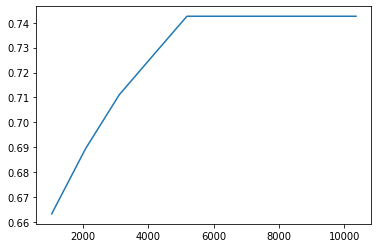

In [54]:
x_data = []
y_data = []
for i in range(step, last_zero_iteration_index, step):
    y_data.append(experiments[int(i/step)-1]['predict masked case'])
    x_data.append(i)
    
plt.plot(x_data, y_data)

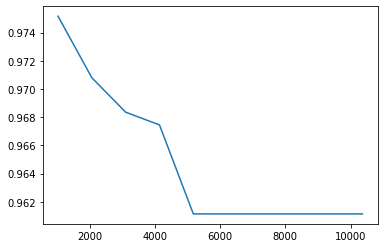

In [58]:
x_data = []
y_data = []
for i in range(step, last_zero_iteration_index, step):
    y_data.append(experiments[int(i/step)-1]['masked prediction accuracy'])
    x_data.append(i)
    
plt.plot(x_data, y_data)

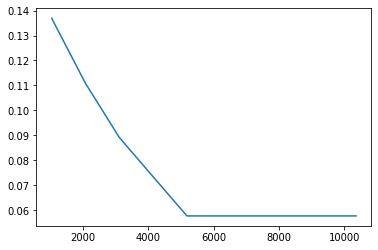

In [55]:
x_data = []
y_data = []
for i in range(step, last_zero_iteration_index, step):
    y_data.append(experiments[int(i/step)-1]['predict SDC case'])
    x_data.append(i)
    
plt.plot(x_data, y_data)

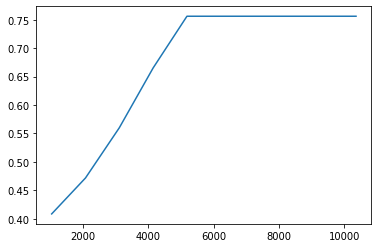

In [57]:
x_data = []
y_data = []
for i in range(step, last_zero_iteration_index, step):
    y_data.append(experiments[int(i/step)-1]['SDC prediction accuracy'])
    x_data.append(i)
    
plt.plot(x_data, y_data)

### Construct Masked Case across the program

predict masked case:  0.7663571208384711

predict SDC case: 0.033870221948212084

masked prediction accuracy: 0.9421776403449229

SDC prediction accuracy: 0.8321956769055745

In [5]:
masked_file_path = "cg_simulation/appstate_10286.log"
sdc_file_path = "cg_simulation/appstate_10300.log"

masked_run = pd.read_csv(masked_file_path,  sep=" ", names=['file', 'linenum', 'variable', 'value'])
sdc_run = pd.read_csv(sdc_file_path, sep=" ", names=['file', 'linenum', 'variable', 'value'])

golden_run_value = np.array(golden_run.value)
masked_run_value = np.array(masked_run.value)
sdc_run_value = np.array(sdc_run.value)

In [70]:
#relative error and absolute error
#for i in range(len(golden_run_value)):
#   if golden_run_value[i] != 0:
#        absolute = abs(golden_run_value[i] -  masked_run_value[i])

false_positive = 0
true_positive = 0
unsure = 0
total = (811 - 160) * 64
for i in range(160, 811):
    diff = abs(golden_run_value[i] -  masked_run_value[i]) 
    for b in range(64):
        if diff > abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] != "Masked":
            #print(cg_fault_injection.diffnormr[i * 64 + b], cg_fault_injection.Variable[i * 64 + b], (diff - abs(cg_fault_injection.out_xor[i * 64 + b])))
            false_positive += 1
            print(i * 64 + b)
        elif diff > abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] == "Masked":
            true_positive += 1
        else:
            unsure += 1
    
    #sdc_diff = abs(golden_run_value[i] -  sdc_run_value[i])
    #for b in range(64):
    #    if sdc_diff < abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] != "SDC":
    #        false_positive += 1
    #    elif sdc_diff < abs(cg_fault_injection.out_xor[i * 64 + b]) and cg_fault_injection.outcome[i * 64 + b] == "SDC":
    #        true_positive += 1
    #    else:
    #        unsure +=1
            
print(false_positive/total)
print(true_positive/total)
print(unsure/total)
    
#print(i, cg_fault_injection.Variable[i], cg_fault_injection.out_xor[i], cg_fault_injection.outcome[i])
#for i in range(243*64,244*64):
#    print(i,cg_fault_injection.Variable[i], cg_fault_injection.out_xor[i], cg_fault_injection.outcome[i])
#print(golden_run_value[243])
#print(len(cg_fault_injection))
#golden_run_value-error_run_value[0:811]

IndexError: index 162 is out of bounds for axis 0 with size 162

In [36]:
number_of_instructions = {}

propagation_path = []

for index in range(100):
    if index in[15731, 16246, 17523]:
        continue
    
    file_path = "cg_simulation/appstate_"+str(index)+".log"
    error_run = pd.read_csv(file_path,  sep=' ')
    
    
    #For different fault injection case, what is the number of different execution dynamic instructions
    if len(error_run) in number_of_instructions:
        number_of_instructions[len(error_run)] += 1
    else:
        number_of_instructions[len(error_run)] = 1
        
    #
    index = min(len(golden_run), len(error_run))
    #result = np.array(golden_run.value, dtype=float)[:index] - np.array(error_run.value, dtype=float)[:index]
    #propagation_elements = golden_run.line[np.where(result != 0)[0]]
    
    #path = "=>"
    #number_of_propagation_element = 5
    #for e in propagation_elements:
    #    if str(e) not in path:
    #        path += str(e)
    #        path += "=>"
    #        number_of_propagation_element -= 1
        
    #    if number_of_propagation_element == 0:
    #        break
    #if path not in propagation_path:
    #    propagation_path.append(path)

## What is the probability of the different number of storing dynamic instructions.
## What is the probability of SDC.

It's expected that if the program ends early, then there an unexpected crash during the program execution in the earlier stage. At the same time, if the program has more execution than it expected. It will have high chance causes silent data corruption.

In [6]:
cg_outcome = cg_fault_injection['outcome'].value_counts()

print(cg_outcome)
print(sum(cg_outcome))
#propagation_path

Masked    47284
SDC        4333
DUE         287
Name: outcome, dtype: int64
51904


In [7]:
number_of_instructions

{810: 88, 920: 4, 1030: 8}

# If you want to rewrite your code.

4. interactive fault injection campaign.

### 1. A sensitive analysis across the whole program with a mapping framework.
A desity scatter plot to understand the input and output sensitivity of the program. User can selective choose the high sensitive data and mapping back to the original visualization.
    
    a. how many clusters in the plot.
    
    b. Where is each of them comes from. 
    
    c. The sample that comes from the fault injection in same location.

#### 2. Explore function level resiliency of the program. What's the difference compare to the source code level?

    a.Explore the resiliency of different program component. Aggregate the data in variable level


#### 3. How to measure the impact of one variable/function over the other?
 


# The number of times a function is called.

In [8]:
counter = {}

line_to_func = {167:'readA', 175:'readB', 33:'waxpby', 25:'matvec', 48:'dot_r2', 75:'solve_cg', 76:'solve_cg',87:'solve_cg',57:'dot', 90:'solve_cg',91:'solve_cg',40:"daxpby", 82:'daxpby',83:'daxpby',84:'daxpby'}

for index, row in golden_run.iterrows():
    key = line_to_func[row['line']]
    if key not in counter:
        counter[key] = 1
    else:
        counter[key] += 1

KeyError: 'line'

In [8]:
number_of_instruction = sum(list(counter.values()))
for item in counter.items():
    print(item[0], item[1]/number_of_instruction * 100)

readA 7.891491985203452
readB 0.9864364981504316
waxpby 2.9593094944512948
matvec 55.24044389642416
dot_r2 5.9186189889025895
solve_cg 2.466091245376079
dot 5.9186189889025895
daxpby 18.618988902589393


# Error Propagation Analysis in one program component.

347


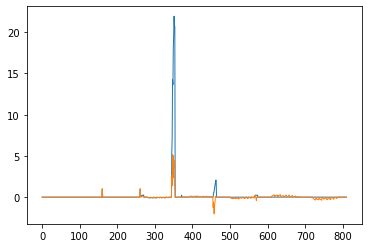

In [9]:
golden_run_path = "cg_simulation/golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
golden_run_value = np.array(golden_run.value)
##### this is a very interesting but werid case
##### There is a NAN occur during the computation, but the  error is masked at the end.
#index_range = [17341, 24381]

##### cg p_ap_dot first interation 64 experiment
#index_range = [15552, 15603]

#file_path = "cg_simulation1/appstate_"+str(17341)+".log"
#error_run = pd.read_csv(file_path,  sep=' ')

#for i in range(len(error_run.value)):
#    print(error_run.line[i], error_run.variable[i], error_run.value[i])
#print(len(error_run.value))

#print(error_run)
#data_set = {}


#golden_run_value = np.array(golden_run.value[0:800], dtype='float')

#for index in range(index_range[0], index_range[1]+1):
#    file_path = "cg_simulation/appstate_"+str(index)+".log"
#    error_run = pd.read_csv(file_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])

#    data_set[index] = golden_run_value - np.array(error_run.value[0:800], dtype='float')


##### a specific case line 75 case 10290
##### a specific case line 75 case 10296
indexs =  [10290, 10274]# 10288] #10297]# 10296, 10289]

delta_x = [65536, 1.0]# 1321922331132047.5]#, -307779.3308780107]
x_data = range(0, 811, 1)

for index,item in enumerate(indexs): 
    file_path = "cg_simulation/appstate_"+str(item)+".log"
    error_run = pd.read_csv(file_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
    error_run_value = np.array(error_run.value)

    sensitivity_val = (error_run_value[0:811] - golden_run_value[0:811])/delta_x[index]
    sns.lineplot(x=x_data, y=sensitivity_val, sort=False, lw=1)
    
print(sensitivity_val.argmax())

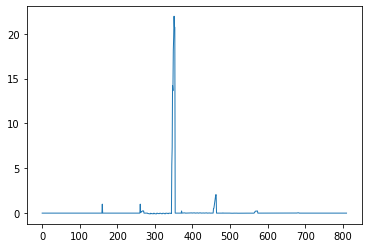

In [12]:
#for index in range(index_range[0], index_range[1]+1):
#    print(len(data_set[index].values))
#data_set[index] = golden_run.values - error_run.values   


x_data = range(0,811,1)
sns.lineplot(x=x_data, y=sensitivity_val, sort=False, lw=1)

#for index in range(index_range[0], index_range[0]+20): 
#    sns.lineplot(x=x_data, y=data_set[index], sort=False, lw=1)

## What role the truncation error is playing in the propagation analysis
## What's the threshold of different program components.
## How much error is masked by the truncate error and How much error is masked by the model feature